In [656]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import gensim.downloader as api
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import spacy

from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from datetime import datetime, timedelta

## Sentiment Model and Analysis

### Load Dataset

In [657]:
reddit_df = pd.read_csv('rsuperstonk_dataset_features.csv')

In [658]:
reddit_df.head()

,Unnamed: 0,id,title,url,score,author,num_comments,date,flair,neg,...,_poss,_intj,_appos,_npadvmod,_predet,_case,_expl,_oprd,_dative,_nmod
0,0,m5y0y9,💎👐,https://i.redd.it/wdwe1cfzoan61.jpg,1,redchessqueen99,1,2021-03-15,NaN,0.0,...,0,0,0,0,0,0,0,0,0,0
1,1,mr74pn,Any 18 year olds ready to be part of the 0.999...,https://www.reddit.com/r/Superstonk/comments/m...,1,Stockboy567,6,2021-04-15,Discussion 🦍,0.0,...,2,0,0,0,0,0,0,0,0,0
2,2,ncqbq1,Bias: Confirmed. Don’t remember following this...,https://i.redd.it/3c20ntl3k7z61.jpg,1,NickGarber17,5,2021-05-15,Fluff ☁,0.0,...,0,0,0,1,0,0,0,0,0,0
3,3,o056kw,Went shopping and saw this. Be careful out the...,https://i.redd.it/li2qzwpasc571.jpg,45,b1naryh3r0,23,2021-06-15,Shitpost 👾,0.0,...,0,0,0,0,0,0,0,0,0,0
4,4,okkwzb,Im about to play video games for the next too ...,https://www.reddit.com/r/Superstonk/comments/o...,1,Laffingglassop,9,2021-07-15,Discussion 🦍,0.0,...,0,0,0,1,0,0,0,0,0,0


### Extract Features

In [659]:
## Handling Missing Values
reddit_df['title'].fillna('', inplace=True)

In [660]:
reddit_df.dtypes


Unnamed: 0     int64
id            object
title         object
url           object
score          int64
               ...  
_case          int64
_expl          int64
_oprd          int64
_dative        int64
_nmod          int64
Length: 74, dtype: object

In [661]:
reddit_df['title'] = reddit_df['title'].astype(str)

In [662]:
reddit_df['title_length'] = reddit_df['title'].apply(len)

### Tokenization

In [663]:
# !pip install nltk

In [664]:
from nltk.tokenize import word_tokenize

reddit_df['tokenized_title'] = reddit_df['title'].apply(word_tokenize)


In [665]:
reddit_df['tokenized_title'].head()

0                                                 [💎👐]
1    [Any, 18, year, olds, ready, to, be, part, of,...
2    [Bias, :, Confirmed, ., Don, ’, t, remember, f...
3    [Went, shopping, and, saw, this, ., Be, carefu...
4    [Im, about, to, play, video, games, for, the, ...
Name: tokenized_title, dtype: object

In [666]:
reddit_df['date'] = pd.to_datetime(reddit_df['date'], errors='coerce')

# Drop rows with NaN values in the 'date' column
reddit_df.dropna(subset=['date'], inplace=True)

# Extract features from the date
reddit_df['day_of_week'] = reddit_df['date'].dt.dayofweek
reddit_df['month'] = reddit_df['date'].dt.month
reddit_df['year'] = reddit_df['date'].dt.year



In [668]:
# # Download NLTK resources
# nltk.download('punkt')
# nltk.download('stopwords')

In [669]:
# Load English language model for spaCy
nlp = spacy.load("en_core_web_sm")

In [670]:
# Preprocess the text data
def preprocess_text(text):
    # Tokenization
    tokens = nltk.word_tokenize(text)
    
    # Stop words removal
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.lower() not in stop_words]
    
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    
    # Join the processed tokens back into a string
    processed_text = ' '.join(tokens)
    
    return processed_text



In [671]:
# Apply preprocessing to the 'text' column
reddit_df['processed_text'] = reddit_df['title'].apply(preprocess_text)

In [672]:

reddit_df.head()


,Unnamed: 0,id,title,url,score,author,num_comments,date,flair,neg,...,_expl,_oprd,_dative,_nmod,title_length,tokenized_title,day_of_week,month,year,processed_text
0,0,m5y0y9,💎👐,https://i.redd.it/wdwe1cfzoan61.jpg,1,redchessqueen99,1,2021-03-15,NaN,0.0,...,0,0,0,0,2,[💎👐],0,3,2021,💎👐
1,1,mr74pn,Any 18 year olds ready to be part of the 0.999...,https://www.reddit.com/r/Superstonk/comments/m...,1,Stockboy567,6,2021-04-15,Discussion 🦍,0.0,...,0,0,0,0,95,"[Any, 18, year, olds, ready, to, be, part, of,...",3,4,2021,18 year old readi part 0.99999999 % group weal...
2,2,ncqbq1,Bias: Confirmed. Don’t remember following this...,https://i.redd.it/3c20ntl3k7z61.jpg,1,NickGarber17,5,2021-05-15,Fluff ☁,0.0,...,0,0,0,0,116,"[Bias, :, Confirmed, ., Don, ’, t, remember, f...",5,5,2021,bia : confirm . ’ rememb follow stupid account...
3,3,o056kw,Went shopping and saw this. Be careful out the...,https://i.redd.it/li2qzwpasc571.jpg,45,b1naryh3r0,23,2021-06-15,Shitpost 👾,0.0,...,0,0,0,0,66,"[Went, shopping, and, saw, this, ., Be, carefu...",1,6,2021,"went shop saw . care , ’ everywher ."
4,4,okkwzb,Im about to play video games for the next too ...,https://www.reddit.com/r/Superstonk/comments/o...,1,Laffingglassop,9,2021-07-15,Discussion 🦍,0.0,...,0,0,0,0,88,"[Im, about, to, play, video, games, for, the, ...",3,7,2021,im play video game next mani hour sound financ...


### Lemmatization

In [104]:
# Lemmatization using spaCy
def lemmatize_text(title):
    doc = nlp(title)
    lemmatized_text = ' '.join([token.lemma_ for token in doc])
    return lemmatized_text

In [105]:
# Apply lemmatization to the 'processed_text' column
reddit_df['lemmatized_text'] = reddit_df['processed_text'].apply(lemmatize_text)

In [673]:
reddit_df.head()

,Unnamed: 0,id,title,url,score,author,num_comments,date,flair,neg,...,_expl,_oprd,_dative,_nmod,title_length,tokenized_title,day_of_week,month,year,processed_text
0,0,m5y0y9,💎👐,https://i.redd.it/wdwe1cfzoan61.jpg,1,redchessqueen99,1,2021-03-15,NaN,0.0,...,0,0,0,0,2,[💎👐],0,3,2021,💎👐
1,1,mr74pn,Any 18 year olds ready to be part of the 0.999...,https://www.reddit.com/r/Superstonk/comments/m...,1,Stockboy567,6,2021-04-15,Discussion 🦍,0.0,...,0,0,0,0,95,"[Any, 18, year, olds, ready, to, be, part, of,...",3,4,2021,18 year old readi part 0.99999999 % group weal...
2,2,ncqbq1,Bias: Confirmed. Don’t remember following this...,https://i.redd.it/3c20ntl3k7z61.jpg,1,NickGarber17,5,2021-05-15,Fluff ☁,0.0,...,0,0,0,0,116,"[Bias, :, Confirmed, ., Don, ’, t, remember, f...",5,5,2021,bia : confirm . ’ rememb follow stupid account...
3,3,o056kw,Went shopping and saw this. Be careful out the...,https://i.redd.it/li2qzwpasc571.jpg,45,b1naryh3r0,23,2021-06-15,Shitpost 👾,0.0,...,0,0,0,0,66,"[Went, shopping, and, saw, this, ., Be, carefu...",1,6,2021,"went shop saw . care , ’ everywher ."
4,4,okkwzb,Im about to play video games for the next too ...,https://www.reddit.com/r/Superstonk/comments/o...,1,Laffingglassop,9,2021-07-15,Discussion 🦍,0.0,...,0,0,0,0,88,"[Im, about, to, play, video, games, for, the, ...",3,7,2021,im play video game next mani hour sound financ...


In [674]:
# Assuming 'title' is the column with Reddit post titles
gamestop_related = reddit_df[reddit_df['title'].str.lower().str.contains('gamestop', 'gme')]

# Now, apply sentiment analysis, topic modeling, and word embeddings to the filtered data


In [676]:
#pip install gensim


### Sentiment Analysis

In [677]:
# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()



In [678]:
# Calculate sentiment scores using VADER for each GameStop-related post title
gamestop_related['vader_sentiment'] = gamestop_related['title'].apply(lambda x: analyzer.polarity_scores(x)['compound'])


/var/folders/_5/kctvxtcx61x5gst0123hf5x00000gn/T/ipykernel_72629/1119710752.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gamestop_related['vader_sentiment'] = gamestop_related['title'].apply(lambda x: analyzer.polarity_scores(x)['compound'])


In [679]:
def get_sentiment_label(vader_sentiment):
    neutral_threshold = 0.25
    if vader_sentiment >= neutral_threshold:
        return 'positive'
    elif vader_sentiment <= -neutral_threshold:
        return 'negative'
    else:
        return 'neutral'

gamestop_related['sentiment_label'] = gamestop_related['vader_sentiment'].apply(get_sentiment_label)


/var/folders/_5/kctvxtcx61x5gst0123hf5x00000gn/T/ipykernel_72629/1288299714.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gamestop_related['sentiment_label'] = gamestop_related['vader_sentiment'].apply(get_sentiment_label)


In [680]:
sentiment_distribution = gamestop_related['sentiment_label'].value_counts()
print(sentiment_distribution)


sentiment_label
neutral     12151
positive     8689
negative     2997
Name: count, dtype: int64


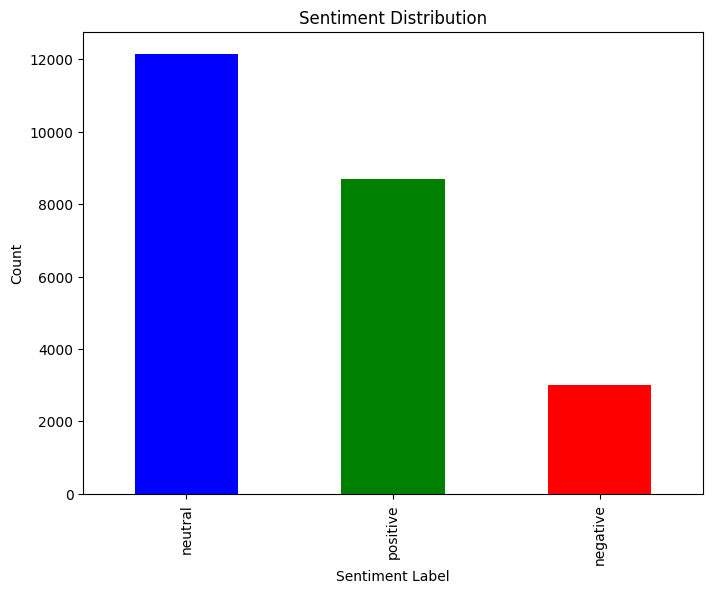

In [681]:
# Plotting sentiment distribution
plt.figure(figsize=(8, 6))
sentiment_distribution.plot(kind='bar', color=['blue', 'green', 'red'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.show()


In [682]:
# Assuming 'date' is the timestamp column
gamestop_related['date'] = pd.to_datetime(gamestop_related['date'])  # Convert to datetime if not already

print(
    
gamestop_related['date'].min(),
gamestop_related['date'].max()
)

2021-03-28 00:00:00 2022-02-14 00:00:00


/var/folders/_5/kctvxtcx61x5gst0123hf5x00000gn/T/ipykernel_72629/4092809422.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gamestop_related['date'] = pd.to_datetime(gamestop_related['date'])  # Convert to datetime if not already


In [683]:
gamestop_related.head()

,Unnamed: 0,id,title,url,score,author,num_comments,date,flair,neg,...,_dative,_nmod,title_length,tokenized_title,day_of_week,month,year,processed_text,vader_sentiment,sentiment_label
10,10,mf4ite,Another Gamestop Sale!!!,https://www.gamespot.com/articles/gamestops-bi...,1,redchessqueen99,1,2021-03-28,Discussion,0.00,...,0,0,24,"[Another, Gamestop, Sale, !, !, !]",6,3,2021,anoth gamestop sale ! ! !,0.0000,neutral
107,107,ncqib6,"Straight from the SEC website, speech that was...",https://i.redd.it/8rlh08vbm7z61.jpg,1,RealisticChair2,71,2021-05-15,Discussion 🦍,0.08,...,0,0,168,"[Straight, from, the, SEC, website, ,, speech,...",5,5,2021,"straight sec websit , speech given today “ con...",0.8555,positive
137,137,ncqlao,I am not a GameStop,https://i.redd.it/weqhpjlcn7z61.jpg,1,OctagonalSquare,5,2021-05-15,Stonky Pets 🐱‍👤,0.00,...,0,0,19,"[I, am, not, a, GameStop]",5,5,2021,gamestop,0.0000,neutral
162,162,ncqmpz,GameStop and Silver: Welcome to the End Game,https://www.reddit.com/r/Superstonk/comments/n...,1,Ago0330,6,2021-05-15,Education 👨‍🏫 | Data 🔢,0.00,...,0,0,44,"[GameStop, and, Silver, :, Welcome, to, the, E...",5,5,2021,gamestop silver : welcom end game,0.4588,positive
189,189,oklkh0,"Take a look at bullet points 2, 4, 9 &amp; 10 ...",https://i.redd.it/cmq8yjwa1bb71.png,1,goodyearbelt,0,2021-07-15,Discussion 🦍,0.00,...,0,0,297,"[Take, a, look, at, bullet, points, 2, ,, 4, ,...",3,7,2021,"take look bullet point 2 , 4 , 9 & amp ; 10 ga...",0.5106,positive


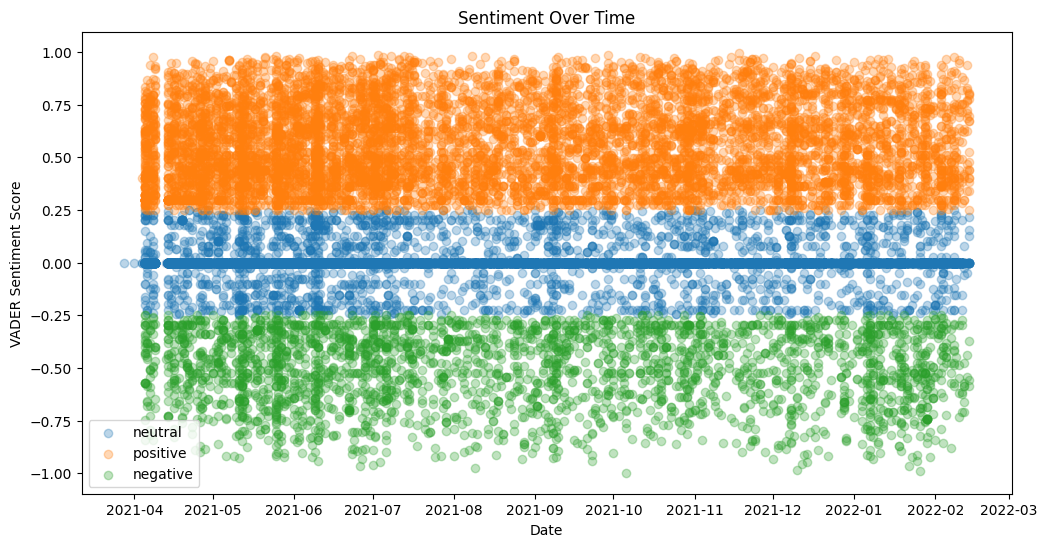

In [684]:
# Plot sentiment over time
plt.figure(figsize=(12, 6))
for label in gamestop_related['sentiment_label'].unique():
    subset = gamestop_related[gamestop_related['sentiment_label'] == label]
    plt.scatter(subset['date'], subset['vader_sentiment'], label=label, alpha=0.3)

plt.title('Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('VADER Sentiment Score')
plt.legend()
plt.show()

In [685]:
# Example: Compare sentiment across different subreddits
subreddit_sentiment = gamestop_related.groupby('title')['sentiment_label'].value_counts().unstack().fillna(0)
print(subreddit_sentiment)


sentiment_label                                     negative  neutral  \
title                                                                   
!!!Coming in live from the Great White North!!!...       0.0      0.0   
!!BUY THE DIP!! THIS IS GAMESTOP SELLING THOSE ...       0.0      0.0   
" Gamestop hasn't said anything for the last mo...       0.0      1.0   
" I continue to recommend shorting GameStop and...       0.0      1.0   
" ‘GameStop: Rise of the Players’: Bonkers stoc...       0.0      1.0   
...                                                      ...      ...   
🦙🦙🦙🦙🦙🦙🦙💰💰💰💰💰💰💰💰 LOOT LLAMA first result when se...       0.0      1.0   
🦺GAMESTOP HEADQUARTERS, FLOAT SECURED. WHAT IS ...       0.0      0.0   
🧠🚨 Wrinkle Alarm: GameStop’s Latest Tweet is BU...       0.0      0.0   
🧱 🧱 🧱Brick by Brick with Zk-Rollup ft. Christof...       0.0      1.0   
🪑 @gamestop                                              0.0      1.0   

sentiment_label                                   

In [686]:
positive_posts = gamestop_related[gamestop_related['sentiment_label'] == 'positive']
negative_posts = gamestop_related[gamestop_related['sentiment_label'] == 'negative']
neutral_posts = gamestop_related[gamestop_related['sentiment_label'] == 'neutral']


In [687]:
sample_posts = gamestop_related.sample(50)
for index, row in sample_posts.iterrows():
    print(f"Title: {row['title']}")
    print(f"VADER Sentiment: {row['vader_sentiment']}")
    print(f"Assigned Label: {row['sentiment_label']}\n")


Title: Flexa on Twitter: GameStop payments now available thru FLEXA!
VADER Sentiment: 0.0
Assigned Label: neutral

Title: Can't anybody READ??? It's SO OBVIOUS how this works. Immutable X is the dildo, Loopring is my ass, and Gamestop is the photographer who will sell my butt photos to greasy old men. Come on people, keep up.
VADER Sentiment: -0.6174
Assigned Label: negative

Title: Father says we come from old GameStop money
VADER Sentiment: 0.0
Assigned Label: neutral

Title: All thanks to RC who saw the opportunity to take a beaten down GameStop and "do something that nobody in the retail space has ever done." AND IT COSTS NOTHING TO HOLD!
VADER Sentiment: 0.4926
Assigned Label: positive

Title: GameStop completed their share offering?
VADER Sentiment: 0.296
Assigned Label: positive

Title: Movie stock using GameStop NFT Marketplace?? I'm all for it. Mass adoption is key! - "Sticky floor, GameStop Could Team Up On NFTs: What Investors Should Know About 'Match Made In Heaven'"
VADER 

In [695]:
#Split the data into training and testing sets
train_data, test_data = train_test_split(gamestop_related, test_size=0.2, random_state=42)

# Create a bag-of-words model using CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
X_train = vectorizer.fit_transform(train_data['title'])
X_test = vectorizer.transform(test_data['title'])

# Create a Naive Bayes classifier
clf = MultinomialNB()

# Train the classifier
clf.fit(X_train, train_data['sentiment_label'])

# Make predictions on the test set
predictions = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(test_data['sentiment_label'], predictions)
print(f"Accuracy: {accuracy:.2f}")

# Display classification report
print("Classification Report:")
print(classification_report(test_data['sentiment_label'], predictions))

Accuracy: 0.73
Classification Report:
              precision    recall  f1-score   support

    negative       0.68      0.34      0.45       603
     neutral       0.77      0.80      0.79      2505
    positive       0.69      0.78      0.73      1660

    accuracy                           0.73      4768
   macro avg       0.71      0.64      0.66      4768
weighted avg       0.73      0.73      0.73      4768



## Prediction Model and Analysis

### Load Dataset

In [746]:
import yfinance as yf

# Define the ticker symbol for GameStop
ticker_symbol = 'GME'

# Specify the start and end dates for the data retrieval
start_date = '2020-01-01'
end_date = '2021-12-31'

# Fetch historical data using yfinance
gme_data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Print the fetched data
print(gme_data.head())


[*********************100%%**********************]  1 of 1 completed

              Open    High     Low   Close  Adj Close    Volume
Date                                                           
2020-01-02  1.5350  1.6175  1.5175  1.5775     1.5775  17814400
2020-01-03  1.5525  1.5625  1.4600  1.4700     1.4700  14175600
2020-01-06  1.4500  1.4775  1.4000  1.4625     1.4625  13579200
2020-01-07  1.4425  1.4575  1.3600  1.3800     1.3800  20912000
2020-01-08  1.3725  1.4625  1.3525  1.4300     1.4300  22517600


In [747]:
df = gme_data

In [748]:
df.shape

(504, 6)

In [749]:
df.tail(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-16,38.232498,38.610001,35.532501,36.147499,36.147499,8659200
2021-12-17,35.937500,39.642502,34.832500,38.910000,38.910000,17226800
2021-12-20,38.297501,39.919998,37.424999,39.285000,39.285000,7314400
2021-12-21,39.264999,40.062500,38.785000,39.529999,39.529999,5720800
2021-12-22,39.582500,39.787498,38.029999,38.500000,38.500000,4188800
2021-12-23,38.500000,38.750000,36.505001,38.035000,38.035000,4222000
2021-12-27,38.000000,38.154999,35.000000,37.077499,37.077499,6454400
2021-12-28,36.875000,39.352501,36.602501,36.615002,36.615002,5324400
2021-12-29,36.962502,38.872501,35.535000,38.482498,38.482498,8149600


In [750]:
df.tail(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-16,38.232498,38.610001,35.532501,36.147499,36.147499,8659200
2021-12-17,35.937500,39.642502,34.832500,38.910000,38.910000,17226800
2021-12-20,38.297501,39.919998,37.424999,39.285000,39.285000,7314400
2021-12-21,39.264999,40.062500,38.785000,39.529999,39.529999,5720800
2021-12-22,39.582500,39.787498,38.029999,38.500000,38.500000,4188800
2021-12-23,38.500000,38.750000,36.505001,38.035000,38.035000,4222000
2021-12-27,38.000000,38.154999,35.000000,37.077499,37.077499,6454400
2021-12-28,36.875000,39.352501,36.602501,36.615002,36.615002,5324400
2021-12-29,36.962502,38.872501,35.535000,38.482498,38.482498,8149600


In [751]:
# Convert 'Date' to datetime index if not already
df.index = pd.to_datetime(df.index)

# Filter the DataFrame for the specified date range
start_date = '2021-06-01'
end_date = '2021-06-30'
filtered_df = df.loc[(df.index >= start_date) & (df.index <= end_date)]

# Extract the values from the 'Close' column
close_prices_june = filtered_df['Close'].values

print(close_prices_june)

[62.25500107 70.55999756 64.54499817 62.09000015 70.00250244 75.
 75.63999939 55.09749985 58.33499908 57.36000061 55.625      55.74250031
 55.89749908 53.45500183 50.09249878 55.09999847 54.83499908 53.07749939
 52.37749863 53.3125     52.72000122 53.53499985]


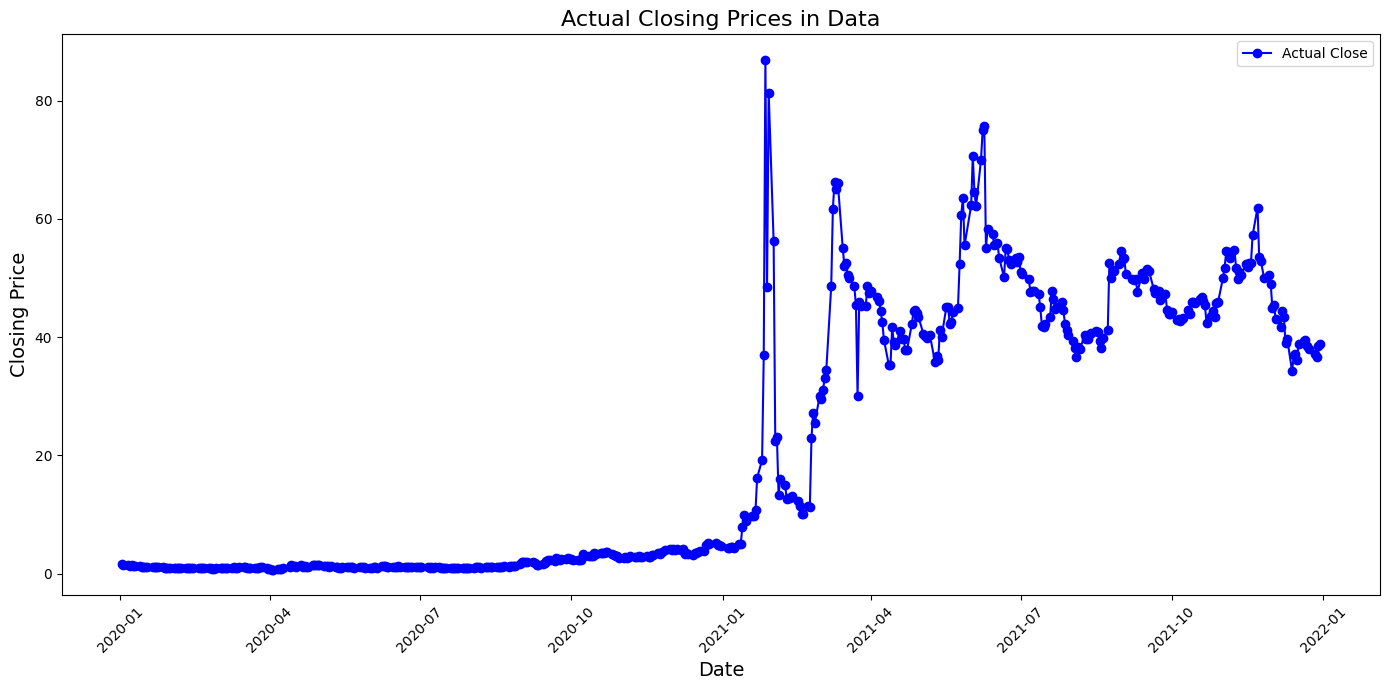

In [752]:
plt.figure(figsize=(14, 7))

# Plotting the actual closing prices in the training period
plt.plot(df.index, df['Close'], label='Actual Close', color='blue', marker='o')

# Adding title and labels with font size adjustments
plt.title('Actual Closing Prices in Data', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price', fontsize=14)

# Rotating date labels for better visibility
plt.xticks(rotation=45)

# Adding a legend to distinguish the actual values
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


In [754]:

df.sort_values('Date', inplace=True)

close_prices = df['Close'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close_prices = scaler.fit_transform(close_prices)

In [755]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,1.535000,1.617500,1.517500,1.577500,1.577500,17814400
2020-01-03,1.552500,1.562500,1.460000,1.470000,1.470000,14175600
2020-01-06,1.450000,1.477500,1.400000,1.462500,1.462500,13579200
2020-01-07,1.442500,1.457500,1.360000,1.380000,1.380000,20912000
2020-01-08,1.372500,1.462500,1.352500,1.430000,1.430000,22517600
...,...,...,...,...,...,...
2021-12-23,38.500000,38.750000,36.505001,38.035000,38.035000,4222000
2021-12-27,38.000000,38.154999,35.000000,37.077499,37.077499,6454400
2021-12-28,36.875000,39.352501,36.602501,36.615002,36.615002,5324400


In [756]:
scaled_close_prices


array([[1.01824719e-02],
       [8.93504707e-03],
       [8.84801678e-03],
       [7.89069058e-03],
       [8.47088786e-03],
       [7.97772087e-03],
       [7.62960112e-03],
       [7.62960112e-03],
       [5.54088953e-03],
       [5.25079090e-03],
       [5.27980007e-03],
       [5.65692899e-03],
       [5.19277117e-03],
       [5.10574088e-03],
       [5.27980007e-03],
       [4.40950415e-03],
       [4.29346470e-03],
       [4.09039496e-03],
       [3.85831605e-03],
       [3.27811808e-03],
       [3.01702861e-03],
       [3.33613780e-03],
       [3.68425686e-03],
       [4.00336467e-03],
       [3.88732522e-03],
       [2.92999902e-03],
       [3.30712794e-03],
       [3.53920685e-03],
       [4.03237523e-03],
       [3.80029632e-03],
       [3.53920685e-03],
       [3.65524631e-03],
       [3.91633577e-03],
       [3.88732522e-03],
       [3.59722658e-03],
       [2.61089052e-03],
       [2.20475173e-03],
       [1.71158404e-03],
       [1.94366296e-03],
       [2.32079119e-03],


In [757]:
scaled_close_prices.shape

(504, 1)

In [758]:
df = df.reset_index()

In [759]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,1.535000,1.617500,1.517500,1.577500,1.577500,17814400
1,2020-01-03,1.552500,1.562500,1.460000,1.470000,1.470000,14175600
2,2020-01-06,1.450000,1.477500,1.400000,1.462500,1.462500,13579200
3,2020-01-07,1.442500,1.457500,1.360000,1.380000,1.380000,20912000
4,2020-01-08,1.372500,1.462500,1.352500,1.430000,1.430000,22517600
...,...,...,...,...,...,...,...
499,2021-12-23,38.500000,38.750000,36.505001,38.035000,38.035000,4222000
500,2021-12-27,38.000000,38.154999,35.000000,37.077499,37.077499,6454400
501,2021-12-28,36.875000,39.352501,36.602501,36.615002,36.615002,5324400
502,2021-12-29,36.962502,38.872501,35.535000,38.482498,38.482498,8149600


In [760]:

def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:(i + sequence_length)]
        y = data[i + sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [761]:
SEQUENCE_LENGTH = 20  
X, y = create_sequences(scaled_close_prices, SEQUENCE_LENGTH)

In [762]:
print(X.shape)
print(y.shape)

(484, 20, 1)
(484, 1)


In [763]:
# Split the data into training and test sets (train on data until May 31st)
TRAIN_END_DATE = '2021-05-31'
train_indices = df[df['Date'] <= TRAIN_END_DATE].index
X_train, y_train = X[:train_indices[-1]-SEQUENCE_LENGTH], y[:train_indices[-1]-SEQUENCE_LENGTH]

In [764]:
print(X_train.shape, y_train.shape)

(334, 20, 1) (334, 1)


In [765]:
print(X_train)

[[[0.01018247]
  [0.00893505]
  [0.00884802]
  ...
  [0.00409039]
  [0.00385832]
  [0.00327812]]

 [[0.00893505]
  [0.00884802]
  [0.00789069]
  ...
  [0.00385832]
  [0.00327812]
  [0.00301703]]

 [[0.00884802]
  [0.00789069]
  [0.00847089]
  ...
  [0.00327812]
  [0.00301703]
  [0.00333614]]

 ...

 [[0.50758608]
  [0.50993588]
  [0.50300252]
  ...
  [0.48646689]
  [0.50474308]
  [0.51408427]]

 [[0.50993588]
  [0.50300252]
  [0.49545993]
  ...
  [0.50474308]
  [0.51408427]
  [0.59943137]]

 [[0.50300252]
  [0.49545993]
  [0.46241766]
  ...
  [0.51408427]
  [0.59943137]
  [0.69554115]]]


In [766]:
# Define the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
11/11 [==============================] - 2s 7ms/step - loss: 0.0327
Epoch 2/20
11/11 [==============================] - 0s 6ms/step - loss: 0.0135
Epoch 3/20
11/11 [==============================] - 0s 6ms/step - loss: 0.0118
Epoch 4/20
11/11 [==============================] - 0s 6ms/step - loss: 0.0106
Epoch 5/20
11/11 [==============================] - 0s 7ms/step - loss: 0.0101
Epoch 6/20
11/11 [==============================] - 0s 7ms/step - loss: 0.0097
Epoch 7/20
11/11 [==============================] - 0s 6ms/step - loss: 0.0093
Epoch 8/20
11/11 [==============================] - 0s 7ms/step - loss: 0.0090
Epoch 9/20
11/11 [==============================] - 0s 17ms/step - loss: 0.0087
Epoch 10/20
11/11 [==============================] - 0s 7ms/step - loss: 0.0083
Epoch 11/20
11/11 [==============================] - 0s 7ms/step - loss: 0.0080
Epoch 12/20
11/11 [==============================] - 0s 7ms/step - loss: 0.0079
Epoch 13/20
11/11 [=============================

In [718]:
business_days = pd.date_range(start=pd.to_datetime(TRAIN_END_DATE) + timedelta(days=1), periods=66, freq='B')

In [719]:
business_days

DatetimeIndex(['2021-06-01', '2021-06-02', '2021-06-03', '2021-06-04',
               '2021-06-07', '2021-06-08', '2021-06-09', '2021-06-10',
               '2021-06-11', '2021-06-14', '2021-06-15', '2021-06-16',
               '2021-06-17', '2021-06-18', '2021-06-21', '2021-06-22',
               '2021-06-23', '2021-06-24', '2021-06-25', '2021-06-28',
               '2021-06-29', '2021-06-30', '2021-07-01', '2021-07-02',
               '2021-07-05', '2021-07-06', '2021-07-07', '2021-07-08',
               '2021-07-09', '2021-07-12', '2021-07-13', '2021-07-14',
               '2021-07-15', '2021-07-16', '2021-07-19', '2021-07-20',
               '2021-07-21', '2021-07-22', '2021-07-23', '2021-07-26',
               '2021-07-27', '2021-07-28', '2021-07-29', '2021-07-30',
               '2021-08-02', '2021-08-03', '2021-08-04', '2021-08-05',
               '2021-08-06', '2021-08-09', '2021-08-10', '2021-08-11',
               '2021-08-12', '2021-08-13', '2021-08-16', '2021-08-17',
      

In [720]:
# Get the last sequence from the training data
last_sequence = X_train[-1].reshape((1, SEQUENCE_LENGTH, 1))

In [721]:
# Create a list to hold predictions
predictions = []

# Predict future prices
for i in range(len(business_days)):
    # Get the prediction (scaled value)
    current_prediction = model.predict(last_sequence)[0]

    # Append the prediction
    predictions.append(current_prediction)

    # Update the sequence
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = current_prediction

# Inverse transform the predictions to get actual values
predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Create a DataFrame with the predicted stock prices and dates
predictions_df = pd.DataFrame({
    'Date': business_days,
    'Predicted_Close': predicted_prices.flatten()
})

# Show the prediction results
print(predictions_df)

1/1 [==============================] - 0s 9ms/step


/var/folders/_5/kctvxtcx61x5gst0123hf5x00000gn/T/ipykernel_72629/655113707.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_sequence[0, -1, 0] = current_prediction


1/1 [==============================] - 0s 13ms/step
         Date  Predicted_Close
0  2021-06-01        48.074760
1  2021-06-02        48.520580
2  2021-06-03        47.832664
3  2021-06-04        46.550884
4  2021-06-07        44.983631
..        ...              ...
61 2021-08-25        40.347122
62 2021-08-26        40.367870
63 2021-08-27        40.385921
64 2021-08-30        40.400215
65 2021-08-31        40.410084

[66 rows x 2 columns]


In [722]:
print(predictions_df)

         Date  Predicted_Close
0  2021-06-01        48.074760
1  2021-06-02        48.520580
2  2021-06-03        47.832664
3  2021-06-04        46.550884
4  2021-06-07        44.983631
..        ...              ...
61 2021-08-25        40.347122
62 2021-08-26        40.367870
63 2021-08-27        40.385921
64 2021-08-30        40.400215
65 2021-08-31        40.410084

[66 rows x 2 columns]


In [723]:
# Ensure the 'Date' columns in both DataFrames are in the same format
df['Date'] = pd.to_datetime(df['Date'])
predictions_df['Date'] = pd.to_datetime(predictions_df['Date'])

predictions_with_actuals_df = predictions_df.merge(df[['Date', 'Close']], on='Date', how='left')

# Rename columns for clarity
predictions_with_actuals_df.rename(columns={'Close': 'Actual_Close'}, inplace=True)

# DataFrame with predictions and actual closing prices
print(predictions_with_actuals_df)

         Date  Predicted_Close  Actual_Close
0  2021-06-01        48.074760     62.255001
1  2021-06-02        48.520580     70.559998
2  2021-06-03        47.832664     64.544998
3  2021-06-04        46.550884     62.090000
4  2021-06-07        44.983631     70.002502
..        ...              ...           ...
61 2021-08-25        40.347122     49.912498
62 2021-08-26        40.367870     51.305000
63 2021-08-27        40.385921     51.237499
64 2021-08-30        40.400215     52.299999
65 2021-08-31        40.410084     54.560001

[66 rows x 3 columns]


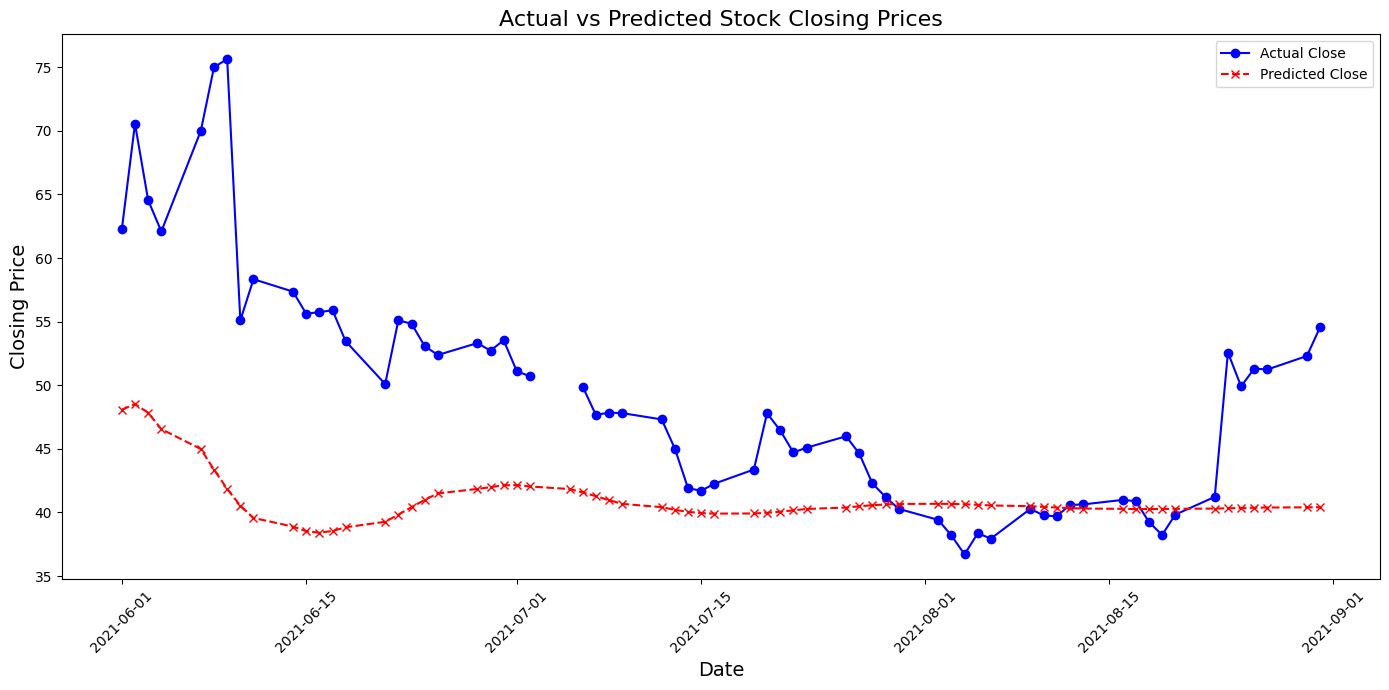

In [724]:
predictions_with_actuals_df['Date'] = pd.to_datetime(predictions_with_actuals_df['Date'])

# Setting the plot size for better readability
plt.figure(figsize=(14, 7))

# Plotting the actual closing prices
plt.plot(predictions_with_actuals_df['Date'], predictions_with_actuals_df['Actual_Close'], label='Actual Close', color='blue', marker='o')

# Plotting the predicted closing prices
plt.plot(predictions_with_actuals_df['Date'], predictions_with_actuals_df['Predicted_Close'], label='Predicted Close', color='red', linestyle='--', marker='x')

# Adding title and labels with font size adjustments
plt.title('Actual vs Predicted Stock Closing Prices', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price', fontsize=14)

# Rotating date labels for better visibility
plt.xticks(rotation=45)

# Adding a legend to distinguish between actual and predicted values
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

The model captures some patterns, it does not properly predict the exact prices though. 

### Combining the models

I decided to combine the datasets to see if there is an improvement in the LSTM model when we add the sentiment scores to it. 

In [810]:
import pandas as pd

# Convert 'date' to datetime if not already
gamestop_related['date'] = pd.to_datetime(gamestop_related['date'])

# Group by 'date' and calculate the mean of 'vader_sentiment' for each date
average_sentiment = gamestop_related.groupby('date')['vader_sentiment'].mean().reset_index()

# Merge DataFrames based on the index of 'df' and 'date' column of 'average_sentiment'
merged_df = df.merge(average_sentiment, left_on='Date', right_on='date', how='left')

# Display the merged DataFrame
print(merged_df)


          Date       Open       High        Low      Close  Adj Close  \
0   2020-01-02   1.535000   1.617500   1.517500   1.577500   1.577500   
1   2020-01-03   1.552500   1.562500   1.460000   1.470000   1.470000   
2   2020-01-06   1.450000   1.477500   1.400000   1.462500   1.462500   
3   2020-01-07   1.442500   1.457500   1.360000   1.380000   1.380000   
4   2020-01-08   1.372500   1.462500   1.352500   1.430000   1.430000   
..         ...        ...        ...        ...        ...        ...   
499 2021-12-23  38.500000  38.750000  36.505001  38.035000  38.035000   
500 2021-12-27  38.000000  38.154999  35.000000  37.077499  37.077499   
501 2021-12-28  36.875000  39.352501  36.602501  36.615002  36.615002   
502 2021-12-29  36.962502  38.872501  35.535000  38.482498  38.482498   
503 2021-12-30  37.750000  40.000000  37.500000  38.832500  38.832500   

       Volume       date  vader_sentiment  
0    17814400        NaT              NaN  
1    14175600        NaT           

/var/folders/_5/kctvxtcx61x5gst0123hf5x00000gn/T/ipykernel_72629/2786512720.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gamestop_related['date'] = pd.to_datetime(gamestop_related['date'])


In [811]:
# Drop rows with NaN values
merged_df_cleaned = merged_df.dropna().reset_index(drop=True)

# Display the cleaned DataFrame
print(merged_df_cleaned)

# Assuming 'close_price' is your close price column in merged_df
target_column = 'Close'
merged_df_cleaned[target_column] = merged_df_cleaned[target_column].shift(-1)  # Shift close prices by one day to predict the next day's closing price

# Drop the last row since it will have NaN in the target column
merged_df_cleaned = merged_df_cleaned.dropna()

# Assuming 'target_column' is now the column you want to predict
target = merged_df_cleaned[target_column].values
merged_df = merged_df_cleaned


          Date       Open       High        Low      Close  Adj Close  \
0   2021-04-01  48.340000  49.242500  45.900002  47.862499  47.862499   
1   2021-04-05  42.750000  48.750000  41.202499  46.737499  46.737499   
2   2021-04-06  46.302502  48.000000  45.889999  46.125000  46.125000   
3   2021-04-07  45.805000  46.125000  44.027500  44.492500  44.492500   
4   2021-04-08  46.470001  46.470001  41.075001  42.564999  42.564999   
..         ...        ...        ...        ...        ...        ...   
184 2021-12-23  38.500000  38.750000  36.505001  38.035000  38.035000   
185 2021-12-27  38.000000  38.154999  35.000000  37.077499  37.077499   
186 2021-12-28  36.875000  39.352501  36.602501  36.615002  36.615002   
187 2021-12-29  36.962502  38.872501  35.535000  38.482498  38.482498   
188 2021-12-30  37.750000  40.000000  37.500000  38.832500  38.832500   

       Volume       date  vader_sentiment  
0    37337200 2021-04-01         0.000000  
1    56282000 2021-04-05         0.

Epoch 1/50
4/4 [==============================] - 1s 3ms/step - loss: 0.1866
Epoch 2/50
4/4 [==============================] - 0s 1ms/step - loss: 0.1788
Epoch 3/50
4/4 [==============================] - 0s 996us/step - loss: 0.1719
Epoch 4/50
4/4 [==============================] - 0s 858us/step - loss: 0.1649
Epoch 5/50
4/4 [==============================] - 0s 1ms/step - loss: 0.1574
Epoch 6/50
4/4 [==============================] - 0s 958us/step - loss: 0.1496
Epoch 7/50
4/4 [==============================] - 0s 1ms/step - loss: 0.1410
Epoch 8/50
4/4 [==============================] - 0s 1ms/step - loss: 0.1327
Epoch 9/50
4/4 [==============================] - 0s 926us/step - loss: 0.1239
Epoch 10/50
4/4 [==============================] - 0s 836us/step - loss: 0.1153
Epoch 11/50
4/4 [==============================] - 0s 845us/step - loss: 0.1066
Epoch 12/50
4/4 [==============================] - 0s 923us/step - loss: 0.0982
Epoch 13/50
4/4 [==============================] - 0s 944us

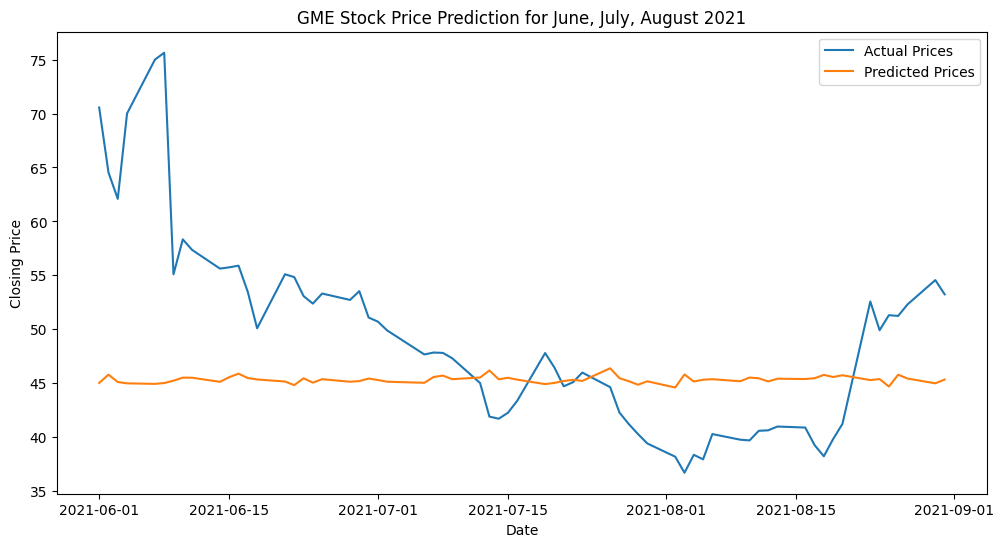

In [812]:
# Filter data for training (exclude June, July, August)
train_data = merged_df[(merged_df['date'] < '2021-06-01') | (merged_df['date'] > '2021-08-31')]

# Prepare sentiment data
X_train_sentiment = np.array(train_data['vader_sentiment'].tolist()).reshape(-1, 1)

# Prepare stock price data
scaler = MinMaxScaler(feature_range=(0, 1))
y_train_stock = scaler.fit_transform(train_data['Close'].values.reshape(-1, 1))

# Build LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(100, input_shape=(1, 1), activation='relu'))
model_lstm.add(Dense(1, activation='linear'))  # Assuming predicting a single continuous value (stock price)
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
model_lstm.fit(X_train_sentiment, y_train_stock, epochs=50, batch_size=32)

# Prepare data for prediction (June, July, August)
test_data = merged_df[(merged_df['date'] >= '2021-06-01') & (merged_df['date'] <= '2021-08-31')]

# Prepare sentiment data for testing
X_test_sentiment = np.array(test_data['vader_sentiment'].tolist()).reshape(-1, 1)

# Predict stock prices using the LSTM model
predictions_stock = model_lstm.predict(X_test_sentiment)

# Inverse transform to get original scale
predictions_stock = scaler.inverse_transform(predictions_stock).flatten()

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(test_data['date'], test_data['Close'], label='Actual Prices')
plt.plot(test_data['date'], predictions_stock, label='Predicted Prices')
plt.title('GME Stock Price Prediction for June, July, August 2021')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()


### Evaluating the Model

In [813]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Evaluate the model on the test set
mse = mean_squared_error(test_data['Close'], predictions_stock)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data['Close'], predictions_stock)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')


Mean Squared Error (MSE): 95.43046755319385
Root Mean Squared Error (RMSE): 9.76885190558204
Mean Absolute Error (MAE): 7.441900928203876


### Sensitivity Analysis 

3/3 [==============================] - 0s 1ms/step


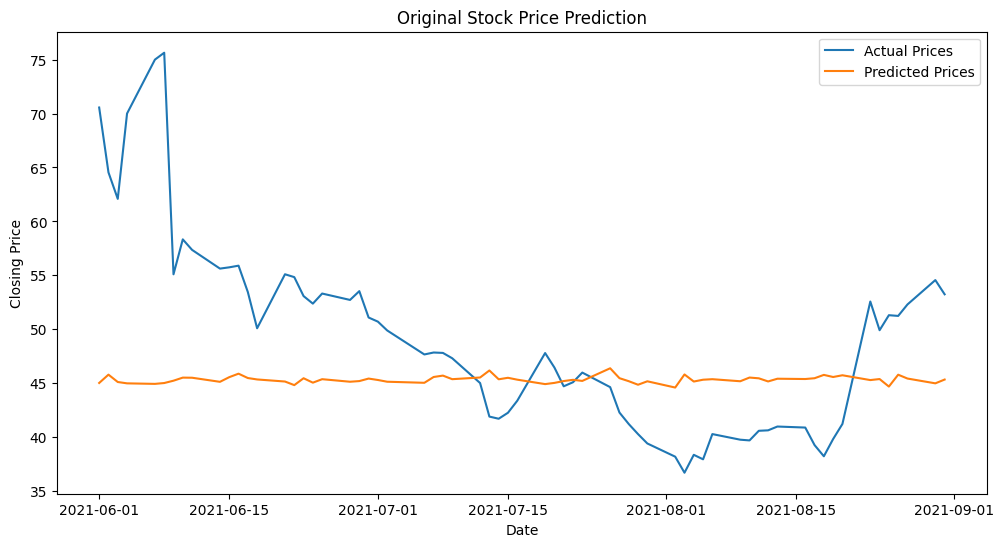

3/3 [==============================] - 0s 1ms/step


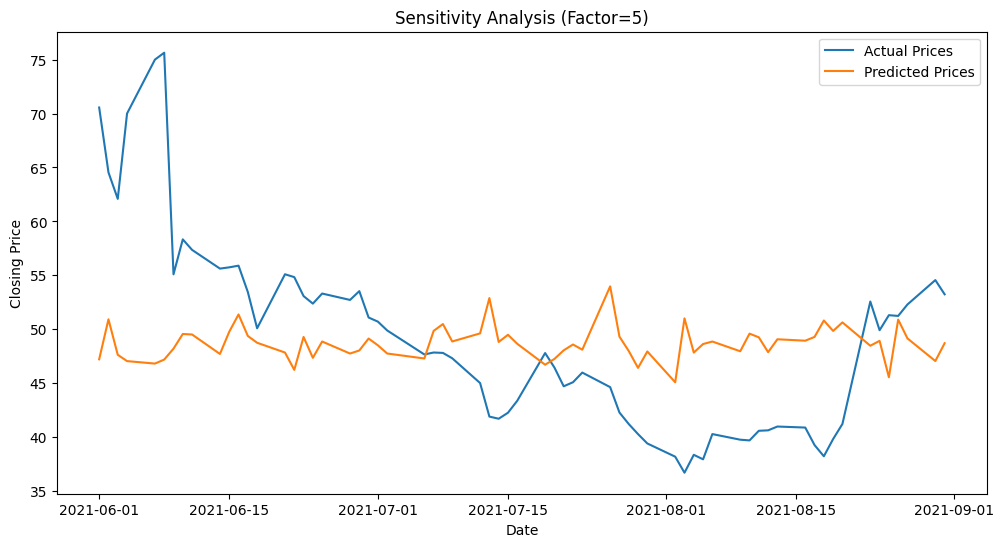

In [816]:
# Function to train LSTM model
def train_lstm_model(X_train_sentiment, y_train_stock):
    model = Sequential()
    model.add(LSTM(50, input_shape=(1, 1), activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train_sentiment, y_train_stock, epochs=50, batch_size=32)
    return model

# Function to predict stock prices and plot results
def predict_and_plot(model, X_test_sentiment, scaler, title='Stock Price Prediction'):
    predictions_stock = model.predict(X_test_sentiment)
    predictions_stock = scaler.inverse_transform(predictions_stock).flatten()

    plt.figure(figsize=(12, 6))
    plt.plot(test_data['date'], test_data['Close'], label='Actual Prices')
    plt.plot(test_data['date'], predictions_stock, label='Predicted Prices')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.show()

# Conduct sensitivity analysis by perturbing sentiment values
sensitivity_factor = 1.1
perturbed_X_test_sentiment = perturb_sentiment(X_test_sentiment, factor=sensitivity_factor)

# Predict stock prices and plot results for original and perturbed data
predict_and_plot(model_lstm, X_test_sentiment, scaler, title='Original Stock Price Prediction')
predict_and_plot(model_lstm, perturbed_X_test_sentiment, scaler, title=f'Sensitivity Analysis (Factor={sensitivity_factor})')